<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

Tutorials to use OpenAI DRL to trade multiple stocks in one Jupyter Notebook | Presented at NeurIPS 2020: Deep RL Workshop

* This blog is based on our paper: FinRL: A Deep Reinforcement Learning Library for Automated Stock Trading in Quantitative Finance, presented at NeurIPS 2020: Deep RL Workshop.
* Check out medium blog for detailed explanations: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- ASSUMES USING DOCKER, see readme for instructions

<a id='1.1'></a>
## 2.1. Add FinRL to your path. You can of course install it as a pipy package, but this is for development purposes.


In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd
print(pd.__version__)

1.1.5



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading_v2 import StockTradingEnvV2
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint




/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [5]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [6]:
# from config.py end_date is a string
config.END_DATE

'2020-12-01'

In [7]:
print(config.DOW_30_TICKER)

['AAPL', 'MSFT', 'JPM', 'V', 'RTX', 'PG', 'GS', 'NKE', 'DIS', 'AXP', 'HD', 'INTC', 'WMT', 'IBM', 'MRK', 'UNH', 'KO', 'CAT', 'TRV', 'JNJ', 'CVX', 'MCD', 'VZ', 'CSCO', 'XOM', 'BA', 'MMM', 'PFE', 'WBA', 'DD']


In [8]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-01-01',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df.shape

(90630, 8)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

date       open       high        low      close       volume   tic  \
0  2009-01-02   3.067143   3.251429   3.041429   2.795913  746015200.0  AAPL   
1  2009-01-02  18.570000  19.520000  18.400000  15.745411   10955700.0   AXP   
2  2009-01-02  42.799999  45.560001  42.779999  33.680935    7010200.0    BA   
3  2009-01-02  44.910000  46.980000  44.709999  32.514400    7117200.0   CAT   
4  2009-01-02  16.410000  17.000000  16.250000  12.683227   40980600.0  CSCO   

   day  
0    4  
1    4  
2    4  
3    4  
4    4

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [11]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [12]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

date       open       high        low      close       volume   tic  \
0  2009-01-02   3.067143   3.251429   3.041429   2.795913  746015200.0  AAPL   
1  2009-01-02  18.570000  19.520000  18.400000  15.745411   10955700.0   AXP   
2  2009-01-02  42.799999  45.560001  42.779999  33.680935    7010200.0    BA   
3  2009-01-02  44.910000  46.980000  44.709999  32.514400    7117200.0   CAT   
4  2009-01-02  16.410000  17.000000  16.250000  12.683227   40980600.0  CSCO   
5  2009-01-02  74.230003  77.300003  73.580002  48.043262   13695900.0   CVX   
6  2009-01-02  21.605234  22.060680  20.993229  14.527276   13251000.0    DD   
7  2009-01-02  22.760000  24.030001  22.500000  20.597496    9796600.0   DIS   
8  2009-01-02  84.019997  87.620003  82.190002  72.844467   14088500.0    GS   
9  2009-01-02  23.070000  24.190001  22.959999  17.909452   14902500.0    HD   

   day  macd  rsi_30     cci_30  dx_30  turbulence  
0    4   0.0   100.0  66.666667  100.0         0.0  
1    4   0.0   100.0  66.666667  100.0         0.0  
2    4   0.0   100.0  66.666667  100.0         0.0  
3    4   0.0   100.0  66.666667  100.0         0.0  
4    4   0.0   100.0  66.666667  100.0         0.0  
5    4   0.0   100.0  66.666667  100.0         0.0  
6    4   0.0   100.0  66.666667  100.0         0.0  
7    4   0.0   100.0  66.666667  100.0         0.0  
8    4   0.0   100.0  66.666667  100.0         0.0  
9    4   0.0   100.0  66.666667  100.0         0.0

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2018-12-31
## Trade data split: 2019-01-01 to 2020-09-30

In [13]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2021-01-01')
print(len(train))
print(len(trade))

75480
15150


In [223]:
import time
milliseconds = int(round(time.time() * 1000))
print(milliseconds)

1610898035101


In [224]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
from copy import deepcopy

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
import random

matplotlib.use("Agg")
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common import logger
import time

class StockTradingEnvV2(gym.Env):
    
    """
    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    
    action space: <share_dollar_purchases>
    
    TODO:
        property for date index - starting point
        

    tests:
        after reset, static strategy should result in same metrics

        buy zero should result in no costs, no assets purchased
        given no change in prices, no change in asset values
    """
    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        df,
        transaction_cost_pct=3e-3,
        date_col_name="date",
        hmax=10,
        turbulence_threshold=None,
        print_verbosity=10,
        reward_scaling=1e-4,
        initial_amount=1e6,
        daily_information_cols=["open", "close", "high", "low", "volume"],
        out_of_cash_penalty=None,
        cache_indicator_data = True,
        daily_reward = None,
        cash_penalty_proportion = 0.1, 
        random_start = True
    ):
        self.df = df
        self.stock_col = "tic"
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.random_start = random_start

        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        if out_of_cash_penalty is None:
            out_of_cash_penalty=-initial_amount*0.5
        self.out_of_cash_penalty = out_of_cash_penalty
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.close_index = self.daily_information_cols.index("close")
        self.state_space = (
            1 + len(self.assets) + len(self.assets) * len(self.daily_information_cols)
        )
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.assets),))
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_space,)
        )
        self.episode = -1  # initialize so we can call reset
        self.episode_history = []
        self.printed_header = False
        self.daily_reward = daily_reward
        self.cache_indicator_data = cache_indicator_data
        self.cached_data = None
        self.cash_penalty_proportion = cash_penalty_proportion
        if self.cache_indicator_data:
            print("caching data")
            self.cached_data = [self.get_date_vector(i) for i, _ in enumerate(self.dates)]
            print("data cached!")
        

    def seed(self, seed=None):
        if seed is None:
            seed = int(round(time.time() * 1000))
        random.seed(seed)
        
    @property
    def current_step(self):
        return self.date_index-self.starting_point


    def reset(self):
        self.seed()
        self.sum_trades = 0
        if self.random_start:
            starting_point = random.choice(range(int(len(self.dates)*0.5)))
            self.starting_point = starting_point
        else:
            self.starting_point = 0
        self.date_index = self.starting_point
        self.episode += 1
        self.actions_memory = []
        self.transaction_memory = []
        self.state_memory = []
        self.account_information = {
            "cash": [],
            "asset_value": [],
            "total_assets": [],
            'reward': []
        }
        init_state = np.array(
                [self.initial_amount]
                + [0] * len(self.assets)
                + self.get_date_vector(self.date_index)
            )
        self.state_memory.append(init_state)
        return init_state

    def get_date_vector(self, date, cols=None):
        if (cols is None) and (self.cached_data is not None):
            return self.cached_data[date]
        else:
            date = self.dates[date]
            if cols is None:
                cols = self.daily_information_cols
            trunc_df = self.df.loc[date]
            v = []
            for a in self.assets:
                subset = trunc_df[trunc_df[self.stock_col] == a]
                v += subset.loc[date, cols].tolist()
            assert len(v) == len(self.assets) * len(cols)
            return v
        
    def return_terminal(self, reason='Last Date', reward=0):

        state = self.state_memory[-1]
        self.log_step(reason = reason, terminal_reward= reward)
        reward = reward*self.reward_scaling
        # Add outputs to logger interface
        reward_pct = self.account_information['total_assets'][-1]/self.initial_amount
        logger.record("environment/total_reward_pct", (reward_pct-1)*100)
        logger.record("environment/daily_trades", self.sum_trades/(self.current_step)/len(self.assets))
        logger.record("environment/completed_steps", self.current_step)
        logger.record("environment/sum_rewards", np.sum(self.account_information['reward']))
        logger.record("environment/cash_proportion", self.account_information['cash'][-1]/self.account_information['total_assets'][-1])
        return state, reward, True, {}
    
    def log_step(self, reason, terminal_reward=None):
        if terminal_reward is None:
            terminal_reward = self.account_information['reward'][-1]
        cash_pct = self.account_information['cash'][-1]/self.account_information['total_assets'][-1]
        rec = [self.episode, self.date_index-self.starting_point, reason, f"${int(self.account_information['total_assets'][-1])}",f"${terminal_reward:0.2f}", f"{cash_pct*100:0.2f}%"]

        self.episode_history.append(rec)
        print(self.template.format(*rec))

    def step(self, actions):
        #let's just log what we're doing in terms of max actions at each step. 
        self.sum_trades += np.sum(np.abs(actions))
        
        #print header only first time
        if self.printed_header is False:
            self.template = "{0:4}|{1:4}|{2:15}|{3:10}|{4:10}|{5:10}" # column widths: 8, 10, 15, 7, 10
            print(self.template.format("EPISODE", "STEPS", "TERMINAL_REASON", "TOT_ASSETS", "TERMINAL_REWARD_unsc", "CASH_PCT"))
            self.printed_header = True

        # define terminal function in scope so we can do something about the cycle being over


        # print if it's time.
        if (self.current_step+ 1) % self.print_verbosity == 0:
            self.log_step(reason = 'update')

        #if we're at the end
        if self.date_index == len(self.dates) - 1:
            #if we hit the end, set reward to total gains (or losses)
            terminal_reward = self.account_information['total_assets'][-1]-self.initial_amount
            return self.return_terminal(reward = terminal_reward)
        else:
            #compute value of cash + assets
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1 : len(self.assets) + 1]
            assert (min(holdings)>=0)
            closings = np.array(self.get_date_vector(self.date_index, cols=["close"]))
            asset_value = np.dot(holdings, closings)

            # reward is (cash + assets) - (cash_last_step + assets_last_step)
            if self.current_step==0:
                reward = 0
            else:
                #stepwise reward
                reward = (
                    begin_cash + asset_value - self.account_information["total_assets"][-1]
                )
                #
                if self.daily_reward is not None:
                    reward+=(self.daily_reward*self.current_step)
                if self.cash_penalty_proportion is not None:
                    cash_penalty = min(0, begin_cash-(self.cash_penalty_proportion*self.initial_amount))
                    reward += cash_penalty

            # log the values of cash, assets, and total assets
            self.account_information["cash"].append(begin_cash)
            self.account_information["asset_value"].append(asset_value)
            self.account_information["total_assets"].append(begin_cash + asset_value)
            self.account_information['reward'].append(reward)

            # multiply action values by our scalar multiplier and save
            actions = actions * self.hmax
            self.actions_memory.append(actions)
            
            
            #scale cash purchases to asset # changes
            actions = actions/closings 
            self.transaction_memory.append(actions)
            
            
            # clip actions so we can't sell more assets than we hold
            actions = np.maximum(actions, -np.array(holdings))


            # compute our proceeds from sales, and add to cash
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells, closings)
            costs = proceeds * self.transaction_cost_pct
            coh = begin_cash + proceeds

            # compute the cost of our buys
            buys = np.clip(actions, 0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend * self.transaction_cost_pct

            # if we run out of cash, end the cycle and penalize
            if (spend + costs) > coh:
                return self.return_terminal(reason = 'CASH SHORTAGE',
                    reward=self.out_of_cash_penalty,
                )

            # verify we didn't do anything impossible here
            assert (spend + costs) <= coh

            # update our holdings
            coh = coh - spend - costs
            holdings_updated = holdings + actions
            self.date_index += 1
            state = (
                [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            )
            self.state_memory.append(state)
            reward = reward * self.reward_scaling
            return state, reward, False, {}

    def get_sb_env(self):
        def get_self():
            return deepcopy(self)
        e = DummyVecEnv([get_self])
        obs = e.reset()
        return e, obs
    
    def get_multiproc_env(self, n = 10):
        def get_self():
            return deepcopy(self)
        e = SubprocVecEnv([get_self for _ in range(n)], start_method = 'fork')
        obs = e.reset()
        return e, obs

    def save_asset_memory(self):
        if self.current_step==0:
            return None
        else:
            self.account_information["date"] = self.dates[- len(self.account_information['cash']):]
            return pd.DataFrame(self.account_information)

    def save_action_memory(self):
        if self.current_step==0:
            return None
        else:
            return pd.DataFrame(
                {"date": self.dates[-len(self.account_information['cash']): ], 
                 "actions": self.actions_memory, 
                 "transactions": self.transaction_memory}
            )



In [136]:
print(StockTradingEnvV2.__doc__)


    A stock trading environment for OpenAI gym
    Parameters:
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
        df (pandas.DataFrame): Dataframe containing data
        transaction_cost (float): cost for buying or selling shares
        hmax (int): max number of share purchases allowed per asset
        turbulence_threshold (float): Maximum turbulence allowed in market for purchases to occur. If exceeded, positions are liquidated
        print_verbosity(int): When iterating (step), how often to print stats about state of env
        reward_scaling (float): Scaling value to multiply reward by at each step. 
        initial_amount: (int, float): Amount of cash initially available
        daily_information_columns (list(str)): Columns to use when building state space from the dataframe. 
        out_of_cash_penalty (int, float): Penalty to apply if the algorithm runs out of cash
    
    action space: <share_dollar_purchases>

    tests:
        af

#### state space
The state space of the observation is as follows 

`start_cash, <owned_shares_of_n_assets>, <<indicator_i_for_asset_j> for j in assets>`

indicators are any daily measurement you can achieve. Common ones are 'volume', 'open' 'close' 'high', 'low'.
However, you can add these as needed, 
The feature engineer adds indicators, and you can add your own as well. 


In [151]:
information_cols = ['open', 'high', 'low', 'close', 'volume', 'day', 'macd', 'rsi_30', 'cci_30', 'dx_30', 'turbulence']

env_kwargs = {
    "hmax": 5000, 
    "daily_reward": 5,
    "out_of_cash_penalty": 0, 
    "cash_penalty_proportion": 0.1,
    "daily_information_cols": information_cols, 
    "print_verbosity": 500, 
    
}
e_train_gym = StockTradingEnvV2(df = train, cache_indicator_data=True,
                              **env_kwargs)

# e_train_obs = StockTradingEnvV2(df = train, cache_indicator_data=False, **env_kwargs)


# e_trade_gym = StockTradingEnvV2(df = train,**env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

caching data
data cached!


## Environment for Training
There are two available environments. The multiprocessing and the single processing env. 
Some models won't work with multiprocessing. 

```python
# single processing
env_train, _ = e_train_gym.get_sb_env()


#multiprocessing
env_train, _ = e_train_gym.get_multiproc_env(n = <n_cores>)
```


In [157]:
# for this example, let's do multiprocessing with n_cores-2

import multiprocessing

n_cores = multiprocessing.cpu_count() - 2
n_cores = 24
print(f"using {n_cores} cores")

# 
e_train_gym.print_verbosity = 500
env_train, _ = e_train_gym.get_multiproc_env(n = n_cores)
# env_train, _ = e_train_gym.get_sb_env()

env_train_obs, _ = e_train_gym.get_sb_env()


using 24 cores
EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [158]:
agent = DRLAgent(env = env_train)

In [159]:
print(config.PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [160]:
from torch.nn import Softsign, ReLU
ppo_params ={'n_steps': 256, 
             'ent_coef': 0.01, 
             'learning_rate': 0.00001, 
             'batch_size': 256, 
            'gamma': 0.99}

policy_kwargs = {
#     "activation_fn": ReLU,
    "net_arch": [1024, 1024, 1024,  1024], 
#     "squash_output": True
}

model = agent.get_model("ppo",  model_kwargs = ppo_params, policy_kwargs = policy_kwargs, verbose = 0)



{'n_steps': 256, 'ent_coef': 0.01, 'learning_rate': 1e-05, 'batch_size': 256, 'gamma': 0.99}


In [ ]:
model.learn(total_timesteps = 10000000, 
            eval_env = env_train_obs, 
            eval_freq = 1000,
            log_interval = 1, 
            tb_log_name = 'cashbuffer_1_16_longrun',
            n_eval_episodes = 1,
            reset_num_timesteps = True)

/opt/conda/lib/python3.6/site-packages/stable_baselines3/common/callbacks.py:327: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7fa85c5f4748> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7fa85c5f45f8>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   1| 499|update         |$1004185  |$5627.42  |93.79%    
   1| 999|update         |$1020146  |$10424.19 |88.03%    
   1|1499|update         |$1109076  |$14779.46 |66.12%    
   1|1813|Last Date      |$1127425  |$127425.60|49.31%    
Eval num_timesteps=24000, episode_reward=1482.79 +/- 0.00
Episode length: 1814.00 +/- 0.00
New best mean reward!


In [162]:
model.save("quicksave_ppo_dow_1_17.model")

In [163]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [164]:
insample_turbulence.turbulence.describe()

count    2516.000000
mean       33.277068
std        33.989003
min         0.000000
25%        15.233736
50%        25.180862
75%        39.290075
max       332.062852
Name: turbulence, dtype: float64

In [165]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [166]:
turbulence_threshold

332.0628518086291

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [225]:
trade = data_split(processed, '2019-01-01','2021-01-01')
env_kwargs = {
    "hmax": 5000, 
    "daily_reward": 5,
    "out_of_cash_penalty": 0, 
    "cash_penalty_proportion": 0.1,
    "daily_information_cols": information_cols, 
    "print_verbosity": 50, 
    "random_start": False,
    "cache_indicator_data": False
    
}
e_trade_gym = StockTradingEnvV2(df = trade,**env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()



In [226]:
print(len(e_trade_gym.dates))

505


In [227]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

EPISODE|STEPS|TERMINAL_REASON|TOT_ASSETS|TERMINAL_REWARD_unsc|CASH_PCT  
   0|  49|update         |$1003820  |$709.09   |87.94%    
   0|  99|update         |$983448   |$-1044.20 |83.67%    
   0| 149|update         |$976661   |$-4920.89 |81.83%    
   0| 199|update         |$968883   |$3067.00  |77.94%    
   0| 249|update         |$971037   |$1296.08  |87.22%    
   0| 299|update         |$919833   |$19610.30 |65.89%    
   0| 349|update         |$896779   |$4621.44  |72.61%    
   0| 399|update         |$895210   |$-1151.45 |68.02%    
   0| 449|update         |$916103   |$2399.57  |73.50%    
   0| 499|update         |$922522   |$958.05   |78.62%    
   0| 504|Last Date      |$923583   |$-76416.46|84.08%    
hit end!


In [218]:
df_account_value.shape

(504, 5)

In [187]:
df_account_value.head(50)

cash    asset_value  total_assets       reward        date
0   1000000.000000       0.000000  1.000000e+06     0.000000  2019-01-03
1    954713.504851   43767.481172  9.984810e+05 -1514.013976  2019-01-04
2    921059.195094   79889.003263  1.000948e+06  2477.212333  2019-01-07
3    898000.392462  103023.607858  1.001024e+06    90.801963  2019-01-08
4    833324.488711  168756.699053  1.002081e+06  1077.187444  2019-01-09
5    840406.267319  161930.011111  1.002336e+06   280.090666  2019-01-10
6    831378.560262  171642.142407  1.003021e+06   714.424239  2019-01-11
7    867326.480855  135434.564406  1.002761e+06  -224.657408  2019-01-14
8    878547.979759  122862.990393  1.001411e+06 -1310.075109  2019-01-15
9    870158.138198  131876.909758  1.002035e+06   669.077804  2019-01-16
10   856458.704083  145370.092272  1.001829e+06  -156.251601  2019-01-17
11   854157.486324  148713.826010  1.002871e+06  1097.515979  2019-01-18
12   839601.817357  165297.845181  1.004900e+06  2088.350203  2019-01-22
13   849032.293973  153013.178698  1.002045e+06 -2789.189867  2019-01-23
14   826812.059251  175033.196129  1.001845e+06  -130.217290  2019-01-24
15   822931.385002  179368.842528  1.002300e+06   529.972150  2019-01-25
16   819012.663201  182538.202776  1.001551e+06  -669.361553  2019-01-28
17   859765.086042  138741.876525  9.985070e+05 -2958.903411  2019-01-29
18   838687.334916  160414.818279  9.991022e+05   685.190629  2019-01-30
19   823536.097213  177945.884349  1.001482e+06  2474.828367  2019-01-31
20   800760.844097  201358.731284  1.002120e+06   737.593820  2019-02-01
21   814279.596213  188486.322468  1.002766e+06   751.343299  2019-02-04
22   796369.333423  206569.777298  1.002939e+06   283.192040  2019-02-05
23   792632.237544  211101.433276  1.003734e+06   909.560098  2019-02-06
24   786157.833973  217246.977425  1.003405e+06  -208.859422  2019-02-07
25   790178.413957  211202.195735  1.001381e+06 -1899.201705  2019-02-08
26   799778.110107  200565.736393  1.000344e+06  -906.763193  2019-02-11
27   796121.992657  204046.529562  1.000169e+06   -40.324281  2019-02-12
28   813972.286893  189151.741155  1.003124e+06  3095.505829  2019-02-13
29   810867.923737  193225.370881  1.004093e+06  1114.266570  2019-02-14
30   793680.022911  210080.989358  1.003761e+06  -182.282349  2019-02-15
31   809270.093136  197783.498745  1.007054e+06  3447.579612  2019-02-19
32   826521.057034  180337.971824  1.006859e+06   -34.563024  2019-02-20
33   818195.886153  188849.075671  1.007045e+06   350.932967  2019-02-21
34   816446.804054  189885.963016  1.006333e+06  -542.194754  2019-02-22
35   810573.116220  197228.686269  1.007802e+06  1644.035418  2019-02-25
36   845948.733139  163362.649064  1.009311e+06  1689.579714  2019-02-26
37   834277.109748  174318.068505  1.008595e+06  -531.203949  2019-02-27
38   835626.556278  173289.144002  1.008916e+06   510.522026  2019-02-28
39   827381.096711  180606.421457  1.007988e+06  -733.182112  2019-03-01
40   834862.521546  173375.739433  1.008238e+06   450.742811  2019-03-04
41   833989.597892  173597.881959  1.007587e+06  -445.781127  2019-03-05
42   851661.198089  155163.822747  1.006825e+06  -552.459016  2019-03-06
43   842768.861599  163183.093706  1.005952e+06  -658.065531  2019-03-07
44   859257.804590  145160.719170  1.004419e+06 -1313.431544  2019-03-08
45   842499.228840  161518.655134  1.004018e+06  -175.639786  2019-03-11
46   832258.858765  174556.424948  1.006815e+06  3027.399739  2019-03-12
47   849127.556444  157492.064512  1.006620e+06    39.337242  2019-03-13
48   878209.089380  128930.002442  1.007139e+06   759.470866  2019-03-14
49   892091.795957  114888.245246  1.006980e+06    85.949381  2019-03-15

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [188]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = BackTestStats(account_value=df_account_value, value_col_name = 'total_assets')
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  -0.31429838045686775
sharpe ratio:  -0.03215222673502538
Annual return         -0.007905
Cumulative returns    -0.015717
Annual volatility      0.097907
Sharpe ratio          -0.032152
Calmar ratio          -0.050407
Stability              0.353511
Max drawdown          -0.156831
Omega ratio            0.993158
Sortino ratio         -0.044483
Skew                  -0.219349
Kurtosis               9.495171
Tail ratio             0.946898
Daily value at risk   -0.012348
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  -0.31429838045686775
sharpe ratio:  -0.03215222673502538
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


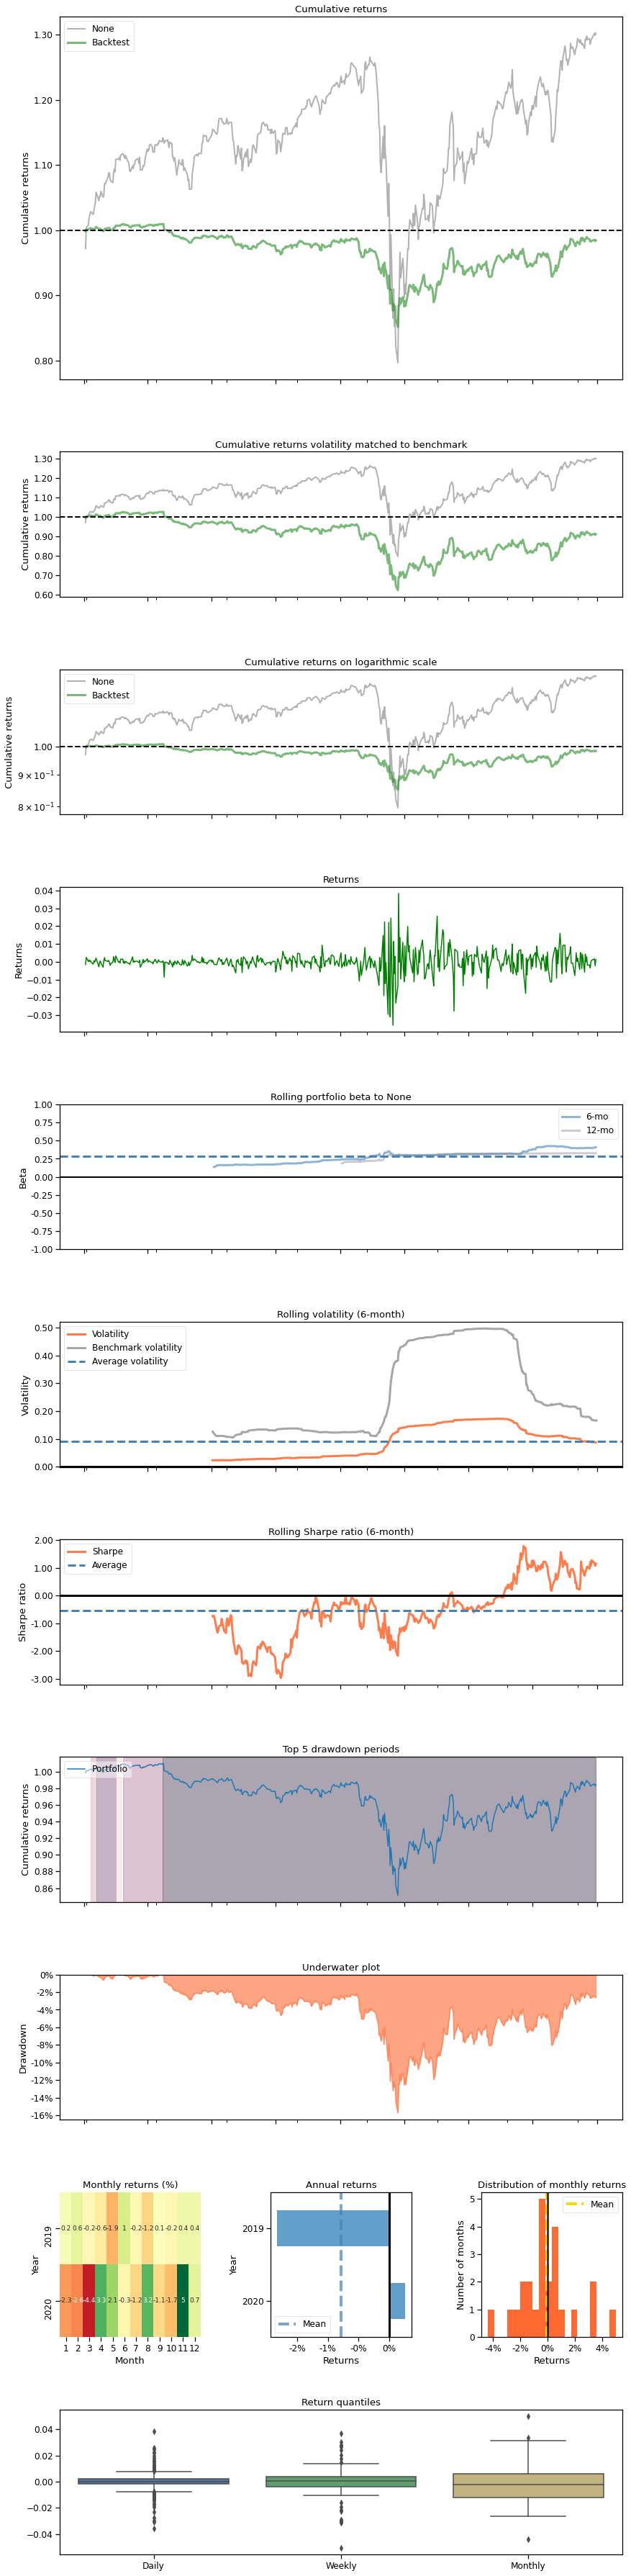

In [189]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01', value_col_name = 'total_assets')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [229]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2021-01-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
Alpha                  0.000000
Beta                   1.000000
dtype: float64
